# Attività nelle soluzioni non ideali

In questa esercitazione, collegata alla lezione 19 del modulo di termodinamica, utilizziamo le capacità offerte dalla libreria [Sympy](https://www.sympy.org/en/index.html) di Python per l'elaborazione *simbolica* di espressioni matematiche, per ottenere il potenziale chimico dei componenti *a* e *b* di una soluzione binaria non ideale e, da quello, derivare l'attività di *a* e di *b*, da confrontarsi con le rispettive frazioni molari. 

Oltre alla libreria numpy, importiamo anche la libreria sympy (con l'alias sym), e invochiamo il comando <i>sym.init_printing</i> per avere un chiaro *rendering* delle espressioni matematiche.

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
%matplotlib inline
sym.init_printing()

In sympy si possono definire dei simboli che possono essere assegnati a variabili python (variabili con lo stesso nome, o anche con nomi diversi da quelle dei simboli). Questi simboli possono poi essere *manipolati* in vario modo seguendo le regole del calcolo algebrico. Per esempio, definiamo due simboli *y* e *z* e poi scriviamone la differenza tra i rispettivi quadrati che assegniamo alla variabile *expr*

In [2]:
y,z=sym.symbols('y z')

In [3]:
expr=(y**2-z**2)
display(expr)

Adesso chiediamo di fattorizzare *expr* e, per far questo, usiamo il metodo *factor*:

In [4]:
expr.factor()

Possiamo poi decidere di derivare *expr* rispetto a *y* e *z*, e di sommare le due derivate:

In [5]:
der=expr.diff(y,1)+expr.diff(z,1)
display(der)

e di raccogliere "2"...

In [6]:
der.factor()

Queste e mille altre operazioni possono essere fatte con sympy... 

Ma veniamo alle soluzioni solide *non* ideali. Cominciamo con il definirci i simboli necessari come le frazioni molari, per le quali specifichiamo anche che sono dei numeri reali positivi (avere informazioni sulle variabili che definiamo, *aiuta* sympy nel fare i conti...)

In [7]:
xa, xb=sym.symbols('x_a x_b', positive=True, real=True)

Poi definiamo i simboli per l'energia libera di soluzione e i potenziali chimici (numeri *reali*):

In [8]:
mu, mua, mub, mu0a, mu0b=sym.symbols('mu mu_a mu_b mu_a^0 mu_b^0', real=True)

Quindi definiamo i simboli per la costante dei gas (R) e per la temperatura (T), che sono numeri reali e positivi, nonché i simboli dei parametri (W e V) che vogliamo usare per costruire un modello di soluzione solida *non* simmetrico:

In [9]:
R,T=sym.symbols('R T', positive=True, real=True)
W, V=sym.symbols('W V', real=True)

Più avanti nel notebook, vorremo avere la possibilità di fare dei calcoli con le espressioni simboliche che abbiamo ottenuto; perciò dovremmo poter attribuire dei valori numerici ai potenziali chimici dei componenti puri, ai parametri W e V, a R e alla temperatura. Questi valori numerici li conserviamo in una variabile che chiamiamo *p* che sia l'istanza di una classe *param*. Dotiamo la classe anche di un metodo *set_T* che consenta di cambiare il valore della temperatura conservata nella variabile p.T:

In [10]:
class param():
    def __init__(self):
        self.R=8.3145
        self.T=1000
        self.W=12000
        self.V=-5000
        self.mu0a=-12000
        self.mu0b=-10000
    def set_T(self,temp):
        self.T=temp
        
p=param()

Adesso siamo pronti per scrivere la funzione $\mu$: l'energia libera molare della nostra soluzione non ideale. Qui andiamo *oltre* il modello quadratico simmetrico discusso nelle lezioni: ne usiamo uno volutamente più complicato (un modello *quartico*, *non simmetrico*) e affideremo alle funzioni per il calcolo simbolico di *Sympy* il compito di derivare le corrette espressioni dei potenziali chimici dei due componenti. 

Sia perciò $Wx_ax_b + Vx_bx_a^3$ il termine non ideale (a due parametri $W$ e $V$) che vogliamo aggiungere all'energia libera della soluzione ideale:

$$\mu = x_a\mu_a^0 + x_b\mu_b^0 + RT\left(x_a \log x_a + x_b\log x_b\right)+Wx_ax_b + Vx_bx_a^3$$

Scriviamo questa espressione come una normale espressione Python, usando le variabili che abbiamo associato ai vari simboli:

In [11]:
mu=xa*mu0a+xb*mu0b+R*T*(xa*sym.log(xa)+xb*sym.log(xb))+W*xa*xb + V*xb*xa**3

Controlliamo che quanto abbiamo scritto corrisponda a ciò che volevamo, usando la funzione *display*:

In [12]:
display(mu)

In effetti l'espressione è corretta, anche se i vari termini sono scritti in un ordine differente. 

Adesso facciamo una cosa *difficile*... ci scriviamo una funzione *mu_f* che ci serva per fare dei grafici di $\mu$ a temperature diverse. Per far questo,

- ci costruiamo un *dizionario* che chiamiamo *parameters*: una lista, messa tra parentesi graffe, di simboli a cui assegniamo una variabile; quindi, con la scrittura "R: p.R" assegniamo al simbolo R la variabile p.R (della classe *param*) che contiene il valore di R (8.3145), perciò il simbolo R sarà sostituito con 8.3145. Lo stesso dicasi per tutti gli altri simboli.

- Sostituiamo le *occorrenze* del simbolo *xb* con il simbolo (1-*xa*), perchè vogliamo ottenere una funzione $\mu(x_a)$ e, in effetti, $x_b=1-x_a$; sostituiamo anche tutti i parametri (W, V, R...) che compaiono in $\mu$ con i valori del dizionario *parameters*. Tutto questo è fatto operando su *mu* con il metodo *subs* (come vedete, possiamo usare due *subs* in cascata). La nuova funzione ottenuta dopo queste sostituzioni viene assegnata alla variabile mu_fp.

- Adesso *lambdifichiamo* (non me ne volete... è un termine *tecnico* di sympy...) la funzione simbolica mu_fp con il metodo *lambdify*: la sintassi di *lambdify* prevede come argomenti: la variabile indipendente (per noi è *xa*), l'espressione da *lambdificare* (ehm... la funzione simbolica da rendere come funzione *lambda*, *anonima*) e un argomento opzionale (in questo caso 'numpy') che dica al metodo di produrre una funzione di tipo *numpy*. La funzione *lambda* ottenuta è assegnata alla variabile *mu_ff* 

Notate che *mu_ff* è una funzione definita all'interno della funzione *mu_f*, quindi è *locale* e non può perciò essere invocata al di fuori di *mu_f*. 

La funzione *mu_f* riceve come argomento la temperatura (*temp*), e lo usa per assegnare il valore della variabile *p.T*, che è poi richiamata nel *dizionario*. *mu_f* costruisce anche una lista *x* di valori della variabile indipendente (*xa*) che restituisce (*return*) insieme ai corrispondenti valori *mu_ff* (valori calcolati per ogni *xa* nella lista *x*) 

In [13]:
def mu_f(temp):
    p.set_T(temp)
    parameters={R: p.R, T: p.T, W: p.W, V: p.V, mu0a: p.mu0a, mu0b: p.mu0b}
    mu_fp=mu.subs(xb,1-xa).subs(parameters)  
    mu_ff=sym.lambdify(xa, mu_fp, 'numpy')
    
    x=np.linspace(0.001, 0.999,50)
    return x, mu_ff(x)

Siamo ora pronti per fare dei plot dell'energia libera della soluzione a varie temperature: 

- Scegliamo 4 temperature diverse che inseriamo nella lista *t_list*;
- apriamo un ciclo sui valori di temperatura contenuti in *t_list* e invochiamo *mu_f* ponendo il suo output nelle variabili *x* e *mx*; 
- il resto è solo grafica...

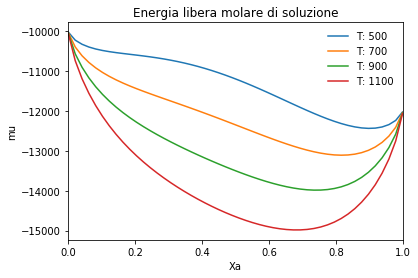

In [14]:
t_list=(500, 700, 900, 1100)

plt.figure()

for it in t_list:     # ciclo su tutti i valori contenuti in t_list
    x, mx=mu_f(it)
    lg="T: "+str(it)
    plt.plot(x,mx,label=lg)

plt.xlim(0,1)
plt.xlabel("Xa")
plt.ylabel("mu")
plt.legend(frameon=False)
plt.title("Energia libera molare di soluzione")
plt.show()

Notate l'andamento della curva per T=500K... descrive un sistema che si *smescola* in due fasi a composizione diversa, come discusso nella lezione termodinamica_19 e nelle dispense.

## Dall'energia libera molare della soluzione ai potenziali chimici

Adesso cominciamo a predisporre le condizioni per calcolare il potenziale chimico di ogni componente. Per far questo, avremo bisogno delle derivate di $\mu$ rispetto ad $x_a$ e rispetto a $x_b$; questo perchè:

<br>

\begin{equation}
\left\{%
\begin{array}{l}
\mu_a = \mu -\left(\frac{\partial\mu}{\partial x_b}\right)x_b\\[6pt]
\mu_b = \mu -\left(\frac{\partial\mu}{\partial x_a}\right)x_a
\end{array}
\right .
\end{equation}

<br>

Perciò, per prima cosa, definiamo due espressioni diverse di $\mu$, di cui una dipenda solo da $x_a$ e l'altra dipenda solo da $x_b$, in modo da poter fare agevolmente appunto le derivate rispetto a $x_a$ e $x_b$. Poniamo queste espressioni, ottenute con il metodo *subs*, nelle variabili *musa* e *musb*:

In [15]:
musa=mu.subs(xb,1-xa)
musb=mu.subs(xa,1-xb)

Quindi, calcoliamo le due derivate di cui sopra con il metodo *diff*. Come argomenti, il metodo accetta la variabile rispetto a cui fare l'integrazione e l'ordine della derivata: per esempio, *musa.diff(xa,1)* farà la derivata prima rispetto a *xa* della funzione *musa* che è la *mu* definita in modo tale da farla dipendere solo da *xa* e non da *xb*. Poniamo le due derivate nelle variabili *dera* e *derb*:

In [16]:
dera=musa.diff(xa,1)
derb=musb.diff(xb,1)

Usando le due variabili *dera* e *derb*, possiamo adesso facilmente calcolare i potenziali chimici dei due componenti (salvati nelle variabili *mub* e *mua*):

In [17]:
mub=mu-dera*xa
mua=mu-derb*xb

Guardiamo cosa abbiamo ottenuto per $\mu_a$:

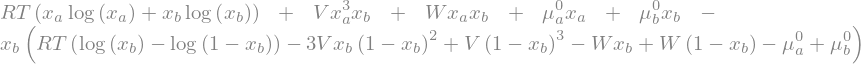

In [18]:
display(mua)

Ummm... Facciamo qualche *semplificazione* e *sostituzione* al fine di ottenere espressioni più facilmente leggibili: 

In [19]:
mua=mua.simplify().subs(xa,1-xb).simplify().subs(1-xb,xa)
mub=mub.simplify().subs(xb,1-xa).simplify().subs(1-xa,xb)

In [20]:
display(mua.collect(V))

OK! Così va decisamente meglio... Vediamo anche $\mu_b$:

In [21]:
display(mub.collect(V))

Vediamo allora di rappresentare queste funzioni; consideriamo $\mu_a$: confrontiamo l'andamento di $\mu_a$ con $x_a$, confrontato con l'andamento del potenziale chimico della stessa componente nel caso ideale. Lo facciamo per una temperatura di 1000K. La procedura non è molto diversa da quella che abbiamo già usato sopra nel caso dell'energia $\mu$: fissiamo la temperatura; sostituiamo in *mua* ogni occorrenza di $x_b$ con $1-x_a$, e tutti i parametri simbolici con i valori contenuti nel dizionario, producendo così *mua_f*; *lambdifichiamo* la funzione *mua_f* (ottenendo *mua_ff*)

In [22]:
p.set_T(1000)
parameters={R:p.R, T:p.T , W: p.W, V: p.V, mu0a: p.mu0a, mu0b: p.mu0b}
mua_f=mua.subs(xb,1-xa).subs(parameters)
mua_ff=sym.lambdify(xa, mua_f, 'numpy')

Definiamo *velocemente* anche le funzioni che calcolano il potenziale chimico dei componenti nel caso ideale:

In [23]:
ideal_a=mu0a+R*T*sym.log(xa)
ideal_b=mu0b+R*T*sym.log(xb)

display(ideal_a)

ideal_af=ideal_a.subs(parameters)
ideal_aff=sym.lambdify(xa,ideal_af,'numpy')

E adesso calcoliamo $\mu_a$ nei casi *ideale* e *non ideale* e facciamone il plot:

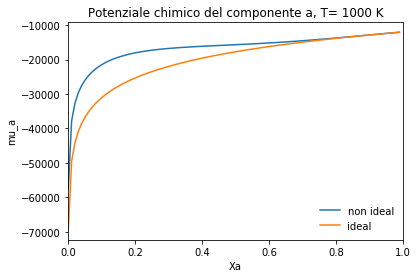

In [24]:
x=np.linspace(0.001,0.990,100)
m=mua_ff(x)
im=ideal_aff(x)

plt.figure()
plt.plot(x,m,label="non ideal")
plt.plot(x,im,label="ideal")
plt.xlim(0,1)
plt.xlabel("Xa")
plt.ylabel("mu_a")
ttl="Potenziale chimico del componente a, T= "+str(p.T)+" K"
plt.title(ttl)
plt.legend(frameon=False, loc='lower right')
plt.show()

Notate come, sia nel caso ideale sia in quello *non* ideale, il potenziale chimico del componente *a* scenda a valori molto bassi al tendere di $x_a$ a 0. Ciò è dovuto al termine logaritmico in *xa*, per cui 

$$
\lim_{x_a \rightarrow 0} \log x_a = -\infty
$$

Questo ci dice che, in generale, il potenziale chimico del componente diventa relativamente molto basso quando sia presente in basse concentrazioni. Se mettiamo a contatto due fasi minerali anche molto diverse (dal punto di vista chimico, strutturale e energetico) è certo che una minima frazione di ogni componente di una delle due fasi, migri nell'altra fase per arrivare a stabilire l'uguaglianza dei potenziali chimici (il componente migra dalla fase dove ha potenziale chimico maggiore verso quella dove ha potenziale chimico minore). Sappiamo per esempio che il calcio non entra negli ortopirosseni; però se mettiamo a contatto del diopside con l'ortoenstatite, possiamo essere certi che una minima traccia di calcio entri nella fase ortorombica, infatti all'equilibrio deve essere:

$$\mu_{Ca}^{diop}=\mu_{Ca}^{ens}$$

<br>

e se fosse $x_{Ca}^{ens}=0$, avremmo $\mu_{Ca}^{ens}=-\infty$ che è sicuramente minore di $\mu_{Ca}^{diop}$. Queste idee si applicano nello stesso modo anche nella geochimica degli *elementi in traccia* che avete già visto: ogni fase minerale deve contenere, seppur in traccia, ogni elemento presente in qualsivoglia concentrazione nell'ambiente in cui il minerale si equilibra dal punto di vista termodinamico.   

## Attività

Come visto nella lezione *termodinamica_19*, ai fini della determinazione dell'attività ($a$) di un componente, ciò che conta è la differenza ($f$) tra il potenziale chimico della soluzione non ideale e il potenziale chimico della corrispondente soluzione ideale. Per esempio, per il componente $a$:

$$
\mu_a^0 + RT\log a_a = \mu_a^0 + RT\log x_a + f \ \rightarrow \ \log a_a = \log x_ae^{f/RT} \ \rightarrow \ a_a=x_ae^{f/RT}
$$

calcoliamo perciò queste differenze nel caso dei due componenti *a* e *b*, e poi definiamone le rispettive attività (*act_a* e *act_b*): 

In [25]:
real_a_ideal=mua-ideal_a
real_b_ideal=mub-ideal_b

act_a=xa*sym.exp(real_a_ideal/(R*T))
act_b=xb*sym.exp(real_b_ideal/(R*T))

Vediamo cosa abbiamo:

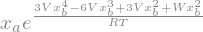

In [26]:
display(act_a)
display(act_b)

Adesso non ci resta che farne i plot: scegliamo due diverse temperature alle quali visualizziamo le curve; naturalmente, come già fatto precedentemente, dovremo sostituire i parametri necessari con i valori del dizionario, *lambdificare*... e:

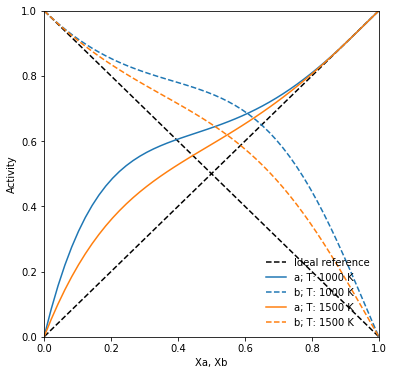

In [27]:
act_p={R:p.R, W: p.W, V: p.V}           # dizionario

act_af=act_a.subs(act_p).subs(xb,1-xa)
act_bf=act_b.subs(act_p).subs(xb,1-xa)

t_list=(1000, 1500)                     # temperature da considerare
x=np.linspace(0.001,0.999,50)           # frazioni molari

plt.figure(figsize=(6,6))
plt.plot(x,x,"k--",label="Ideal reference")
plt.plot(1-x,x,"k--")

for it in t_list:
    p.set_T(it)
    act_af=act_a.subs(act_p).subs(T,p.T).subs(xb,1-xa)
    act_bf=act_b.subs(act_p).subs(T,p.T).subs(xb,1-xa)
    
    act_aff=sym.lambdify(xa, act_af, 'numpy')
    act_bff=sym.lambdify(xa, act_bf, 'numpy')
    
    a_a=act_aff(x)
    a_b=act_bff(x)
    
    lbl_a="a; T: "+str(it)+" K"
    lbl_b="b; T: "+str(it)+" K"
    
    plot_ca=plt.plot(x,a_a, "-",  label=lbl_a)
    color=plot_ca[-1].get_color()
    plt.plot(x,a_b, "--", color=color, label=lbl_b)
    
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Xa, Xb")
plt.ylabel("Activity")
plt.legend(frameon=False, loc='lower right')
plt.show()


Le due linee tratteggiate in nero corrispondono al riferimento ideale (sono le diagonali della figura *quadrata*): $x_a=x_a$ e $x_b=x_a-1$.

Le curve continue in colore rappresentano l'attività del componente $a$, mentre le curve tratteggiate rappresentano l'attività del componente $b$ (notate che l'asse a sinistra corrisponde al componente $b$ puro, mentre quello a destra corrisponde al componente $a$ puro). Come si vede, l'attività è sempre maggiore della frazione molare a causa del termine non ideale *W* che è relativamente grande e positivo; per valori di $x_a$ maggiori di circa 0.7, l'attività $a_a$ è minore di $x_a$ a causa del termine $Vx_bx_a^3$, con $V$ negativo (questo termine diventa preponderante su quello in $W$ per alti valori di $x_a$). 

La curva dell'attività si avvicina al riferimento ideale al salire della temperatura a causa dell'aumento relativo del termine entropico configurazionale (*ideale*).

Provate a sperimentare con valori diversi dei parametri e/o con modifiche della forma dei termini non ideali.

## Un esempio *reale*: l'olivina

Come esempio consideriamo il caso *reale* dell'olivina che forma una soluzione solida che non si allontana molto dal comportamento *ideale*. Il modello implementato nei database termodinamici è *regolare* e *simmetrico* (quindi $W\neq 0$ e $V=0$), con $W=8400$. 

Notate che per fare il calcolo abbiamo bisogno dell'energia libera dei componenti puri alle temperature volute; possiamo allora usare il programma *gibbs_tp.py* che abbiamo usato nelle esercitazioni precedenti per calcolarci la $G$ della forsterite e della fayalite, a mezzo delle funzioni *g_tp*. Perciò carichiamo *gibbs_tp.py* (che deve essere presente nello stesso folder di questo notebook, insieme al database termodinamico di cui fa uso (*perplex_db.dat*). Per evitare *conflitti* con variabili o funzioni che abbiamo già definito in precedenza in questo notebook, anzichè caricare e lanciare *gibbs_tp* con il *magic command*

%run gibbs_tp.py

usiamo una istruzione *import*, e assegniamo l'alias *gibbs*: 

In [28]:
import gibbs_tp as gibbs

Per usare le funzioni di *gibbs_tp* dovremo farle precedere dal suffisso che specifica l'alias; per esempio:

In [29]:
gibbs.fo.info()

Mineral: forsterite

K0: 125.00 GPa, Kp: 4.00, dK0/dT: -0.0187 GPa/K, V0: 4.3660 J/bar
G0: -2053138.00 J/mol, S0:  95.10 J/mol K

Cp coefficients and powers:
+2.3330e+02  +0.0
+1.4940e-03  +1.0
-6.0380e+05  -2.0
-1.8697e+03  -0.5

Alpha coefficients and powers:
+6.1300e-05  +0.0
-6.1300e-04  -0.5


Ora, assegniamo il corretto parametro di Margules per l'olivina (*W*=8400 J/mole) e passiamo a un modello quadratico simmetrico. Possiamo cambiare modello rispetto a quello *quartico asimmetrico* che abbiamo costruito, semplicemente ponendo a zero il parametro *V* (quello del termine $Vx_bx_a^3$):

In [30]:
# Nota informatica:
# assegniamo i valori dei parametri accedendo direttamente 
# alle variabili p.W e p.V, senza passare da metodi appositamente
# predisposti (come, per esempio, per la temperatura). Questa è
# una pratica possibile ma in generale sconsigliata. 
# In molti casi si rendono "private" le variabili
# di una classe, in modo che non siano accessibili
# e/o modificabili se non usando gli opportuni metodi

p.W=8400. 
p.V=0.    # "spegniamo il termine quartico..."

Calcoliamo le attività e i coefficienti di attività di Mg e Fe nell'olivina, alle temperature di 1600 e 2100 K (e pressione 0).

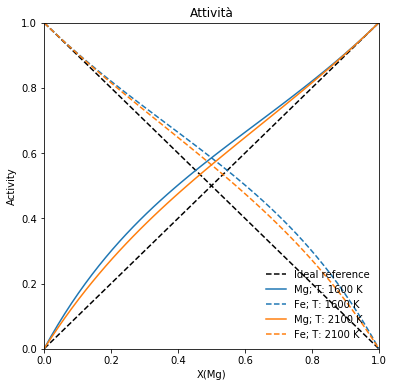

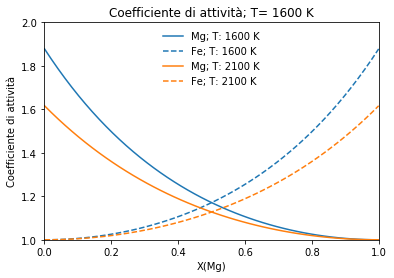

In [31]:
act_p={R:p.R, W: p.W, V: p.V}           # dizionario

act_af=act_a.subs(act_p).subs(xb,1-xa)
act_bf=act_b.subs(act_p).subs(xb,1-xa)

t_list=(1600, 2100)                     # temperature da considerare
x=np.linspace(0.001,0.999,50)           # frazioni molari

plt.figure(figsize=(6,6))
plt.plot(x,x,"k--",label="Ideal reference")
plt.plot(1-x,x,"k--")

ca_a=np.array([])
ca_b=np.array([])
for it in t_list:
    p.mu0a=gibbs.fo.g_tp(it,0)   # energia libera molare della forsterite
                                 # pura, alla temperatura it (e P=0)
    p.mu0b=gibbs.fa.g_tp(it,0)   # energia libera molare della fayalite
    p.set_T(it)
    
    par={T: p.T, mu0a: p.mu0a, mu0b: p.mu0b}
    act_af=act_a.subs(act_p).subs(xb,1-xa).subs(par)
    act_bf=act_b.subs(act_p).subs(xb,1-xa).subs(par)
    
    act_aff=sym.lambdify(xa, act_af, 'numpy')
    act_bff=sym.lambdify(xa, act_bf, 'numpy')
    
    a_a=act_aff(x)
    a_b=act_bff(x)
    
    ica_a=a_a/x
    ica_b=a_b/(1.-x)
    
    ca_a=np.append(ca_a,ica_a)
    ca_b=np.append(ca_b,ica_b)
        
    lbl_a="Mg; T: "+str(it)+" K"
    lbl_b="Fe; T: "+str(it)+" K"
    
    plot_a=plt.plot(x,a_a, "-",  label=lbl_a)
    color=plot_a[-1].get_color()
    plt.plot(x,a_b, "--", color=color, label=lbl_b)
    
ca_a=np.reshape(ca_a,(len(t_list),len(x))) 
ca_b=np.reshape(ca_b,(len(t_list),len(x)))
    
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("X(Mg)")
plt.ylabel("Activity")
plt.legend(frameon=False, loc='lower right')
plt.title("Attività")
plt.show()

plt.figure()
for idx in range(len(t_list)):
    lbla="Mg; T: "+str(t_list[idx])+" K"
    lblb="Fe; T: "+str(t_list[idx])+" K"
    plot_a=plt.plot(x,ca_a[idx],label=lbla)
    color=plot_a[-1].get_color()
    plt.plot(x,ca_b[idx],"--",color=color,label=lblb)

plt.legend(frameon=False)
plt.xlim(0,1)
plt.ylim(1,2)
plt.xlabel("X(Mg)")
plt.ylabel("Coefficiente di attività")
tlt="Coefficiente di attività; T= "+str(t_list[0])+" K"
plt.title(tlt)

plt.show()

Volendo, possiamo modificare leggermente il codice per rappresentare graficamente l'andamento dell'attività del magnesio nell'olivina alle basse concentrazioni (legge di Henry) e alle alte concentrazioni (legge di Rault). Si vedano in proposito le slide della lezione *termodinamica_19*: in particolare, dobbiamo calcolare il limite per $x_a$ che tende a zero della derivata della funzione $a_a$, rispetto a $x_a$, per avere il coefficiente angolare ($m$) della retta tangente alla curva $a_a$ nel punto $x_a=0$; questa retta, che deve passare per l'origine $a_0(0)=0$, definisce la legge di Henry.

$$m=\lim_{x_a\rightarrow 0} \ \frac{da_a}{dx_a}$$

Questo si può fare con Sympy, partendo dalla definizione di $a_a$ che abbiamo costruito sopra e salvato nella variabile *act_a*: 

- sostituiamo tutte le occorrenze di *xb* con 1-*xa*  (metodo *subs*) 
- deriviamo rispetto a *xa*  (metodo *diff*)
- prendiamo il limite per *xa* tendente a 0 (funzione *limit*)


In [32]:
m=sym.limit(act_a.subs(xb,1-xa).diff(xa),xa,0)
display(m)

Questo è il risultato scritto anche nelle slide delle lezioni (comunque è un calcolo che si può fare agevolemente anche a mano, senza usare *sympy*...)

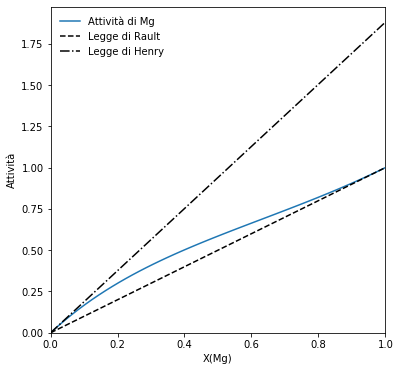

In [33]:
tm=1600                        # temperatura
p.mu0a=gibbs.fo.g_tp(tm,0)    
p.mu0b=gibbs.fa.g_tp(tm,0)    
p.set_T(tm)

par={T: p.T, mu0a: p.mu0a, mu0b: p.mu0b}
act_af=act_a.subs(act_p).subs(xb,1-xa).subs(par)
m_f=m.subs(act_p).subs(par)
    
act_aff=sym.lambdify(xa, act_af, 'numpy')
gamma_0=float(m_f.evalf())     # Coeff. angolare retta di Henry

H0=(0,1)                       # punti per il tracciamento della retta
H1=(0,gamma_0)                 # di Henry

R0=(0,1)                       # punti per il tracciamento della retta
R1=(0,1)                       # di Rault

a_a=act_aff(x)                 # valori dell'attività 
plt.figure(figsize=(6,6))
plt.plot(x,a_a,label="Attività di Mg")
plt.plot(R0,R1,"k--",label="Legge di Rault")
plt.plot(H0,H1,"k-.", label="Legge di Henry")
plt.xlim(0,1)
ymx=gamma_0*(1.+0.05)
plt.ylim(0,ymx)
plt.xlabel("X(Mg)")
plt.ylabel("Attività")
plt.legend(frameon=False)
plt.show()

Come si evince dal grafico, la legge di Henry è approssimativamente rispettata per $x_{\rm Mg}$ variabile da 0 fino a circa 0.1, mentre la legge di Rault può essere considerata valida per $x_{\rm Mg}$ maggiore di circa 0.9. 

### Diagramma *TX* per l'olivina 

Possiamo calcolare il diagramma di stato *TX* dell'olivina utilizzando una versione più sofisticata del programma *melt* che avevamo già usato in una versione passata. Il nuovo programma che usiamo qui si chiama *melt_2* che, oltre a implementare il modello simmetrico (quadratico) per la soluzione solida forsterite-fayalite, presenta delle modifiche alle routine di ottimizzazione che ne aumentano la *stabilità*.

Anche qui è meglio usare una istruzione *import* per caricare il programma (con l'alias *mp*):

In [34]:
import melt_2 as mp

Calcoliamo il diagramma *TX* con il comando *melt* (che facciamo precedere dall'alias *mp*). La lista degli argomenti alla funzione *melt* la possiamo visualizzare con il comando *help*: 

In [35]:
help(mp.melt)

Help on function melt in module melt_2:

melt(ip=0, nt=10, tfmax=0.0, W=8400.0, ideal=False, nt_prt=0)
    Calcola il diagramma di stato TX del sistema fayalite-forsterite
    
    Input:
        ip    - pressione (GPa)
        nt    - numero di punti in temperatura
        tfmax - se non 0, fissa il massimo di temperatura per il grafico
        W     - Parametro di Margules per la soluzione solida
                (default: 8400 J/mole)
        ideal - calcola un diagramma di riferimento ideale (default: False)
        nt_ptr - se > 0 fissa il numero di valori di temperatura per
                 la stampa della tabella T(X) (default: 0; stampa tutti
                 gli nt valori calcolati)



Facciamo il calcolo a 0 GPa, volendo anche le curve calcolate con il modello ideale per il confronto:


Modello simmetrico di soluzione per il solido:
W*Xa*Xb; W= 8400.0 J/mole

Temperatura di fusione della forsterite: 2161.01 K
Temperatura di fusione della fayalite: 1480.31 K


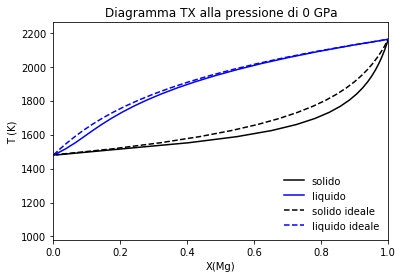


  T (K)   X(Mg)sol  X(Fe)sol  X(Mg)liq  X(Fe)liq
 1480.31    0.01      0.99      0.00      1.00  
 1551.97    0.40      0.60      0.07      0.93  
 1623.62    0.65      0.35      0.12      0.88  
 1695.27    0.78      0.22      0.17      0.83  
 1766.92    0.86      0.14      0.24      0.76  
 1838.58    0.91      0.09      0.32      0.68  
 1910.23    0.94      0.06      0.42      0.58  
 1981.88    0.96      0.04      0.55      0.45  
 2053.53    0.98      0.02      0.70      0.30  
 2125.19    0.99      0.01      0.89      0.11  


In [36]:
mp.melt(0,nt=20,ideal=True,nt_prt=10)

Usiamo la funzione *composition* per calcolare le composizioni a *T* e *P* fissate, per una composizione globale del sistema specifica (per esempio X(Mg)=0.8), sia nel caso ideale, sia in quello non ideale.

In [37]:
help(mp.composition)

Help on function composition in module melt_2:

composition(it, ip, W_val, prt=True, xval=-1.0)
    Determina la composizione delle fasi liquida e solida all'equilibrio
    e le quantità di liquido e solido data una composizione globale
    
    Input:
      it    -  temperatura (K)
      ip    -  pressione (GPa)
      W_val -  parametro di Margules 
      prt   -  stampa i risultati (default: True)
      xval  -  se diverso da -1 calcola le quantita' di solido e liquido
               per la composizione globale xval; se xval=-1 il calcolo
               viene fatto alla composizione per la quale le due curve
               di energia libera si intersecano (default xval = -1)



Caso ideale (W=0.):

In [38]:
mp.composition(1900,0,0.,xval=0.8,prt=True)

Pressione 0.0 GPa,  Temperatura 1900.0 K

Per una composizione X(Mg) globale pari a 0.80: 
X(Mg) fase solida 0.89, quantità fase solida 0.82
X(Mg) fase liquida 0.39, quantità fase liquida 0.18


Caso non ideale (W=8400 J/mole):

In [39]:
mp.composition(1900,0,8400,xval=0.8,prt=True)

Pressione 0.0 GPa,  Temperatura 1900.0 K

Per una composizione X(Mg) globale pari a 0.80: 
X(Mg) fase solida 0.93, quantità fase solida 0.75
X(Mg) fase liquida 0.41, quantità fase liquida 0.25


Da notare le differenze ottenute tra caso ideale e non, sia per quanto riguarda le composizioni delle due fasi, sia per quanto riguarda le quantità relative di fase liquida e solida.

Le funzioni *melt* e *composition* possono essere anche usate specificando pressioni diverse da quella ambiente. Per esempio, a 5 GPa abbiamo: 


Modello simmetrico di soluzione per il solido:
W*Xa*Xb; W= 8400.0 J/mole

Temperatura di fusione della forsterite: 2497.40 K
Temperatura di fusione della fayalite: 1836.95 K


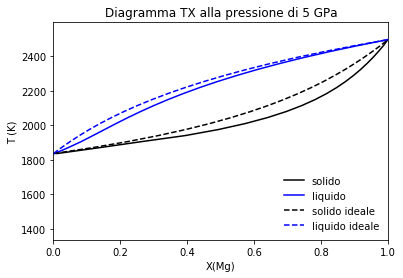


  T (K)   X(Mg)sol  X(Fe)sol  X(Mg)liq  X(Fe)liq
 1836.95    0.01      0.99      0.00      1.00  
 1906.47    0.26      0.74      0.08      0.92  
 1975.99    0.49      0.51      0.15      0.85  
 2045.51    0.64      0.36      0.22      0.78  
 2115.04    0.74      0.26      0.30      0.70  
 2184.56    0.82      0.18      0.39      0.61  
 2254.08    0.87      0.13      0.49      0.51  
 2323.60    0.92      0.08      0.61      0.39  
 2393.12    0.95      0.05      0.75      0.25  
 2462.64    0.99      0.01      0.91      0.09  


In [40]:
mp.melt(5,nt=20,ideal=True,nt_prt=10)